<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 52 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CaseOrder           10000 non-null  int64  
 1   Customer_id         10000 non-null  object 
 2   Interaction         10000 non-null  object 
 3   UID                 10000 non-null  object 
 4   City                10000 non-null  object 
 5   State               10000 non-null  object 
 6   County              10000 non-null  object 
 7   Zip                 10000 non-null  int64  
 8   Lat                 10000 non-null  float64
 9   Lng                 10000 non-null  float64
 10  Population          10000 non-null  int64  
 11  Area                10000 non-null  object 
 12  Timezone            10000 non-null  object 
 13  Job                 10000 non-null  object 
 14  Children            7412 non-null   float64
 15  Age                 7586 non-null   float64
 16  Education

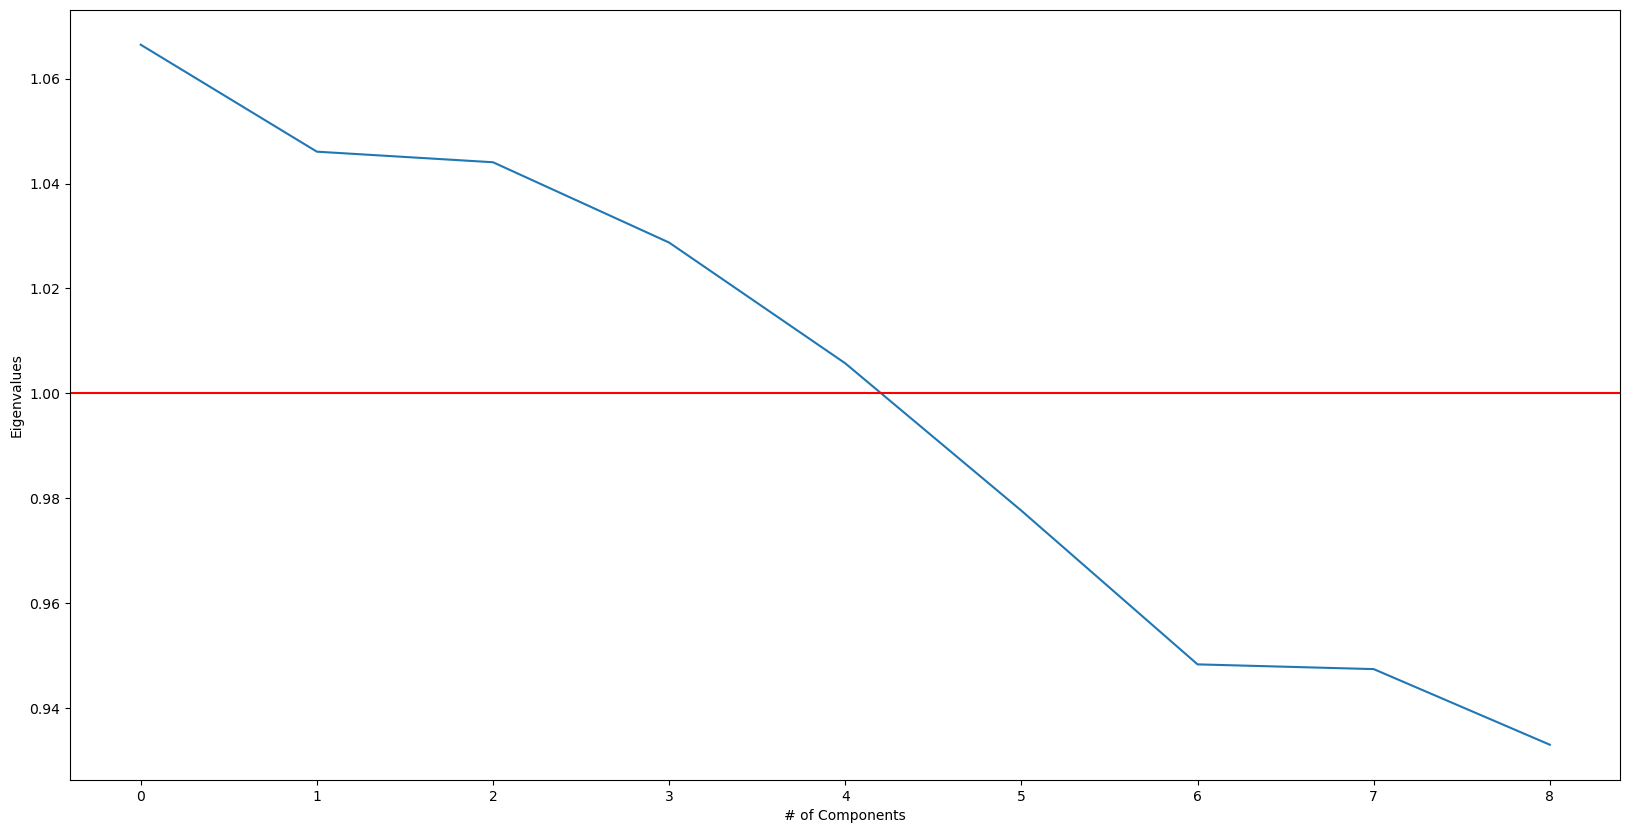

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from scipy import stats

df = pd.read_csv('./medical_raw_data.csv', index_col=0)
# Check the overall dataframe
df.info()
# Conversion of column from int to string and front-fill string with 0's
df['Zip'] = df['Zip'].astype("str").str.zfill(5)

# Replace city-specific values with time-zone specific values
# Define a dictionary to map specific time zones to broader time zones
timezone_mapping = {
    "US - Eastern": [
        "America/New_York", "America/Detroit", "America/Toronto", 
        "America/Indiana/Indianapolis", "America/Indiana/Vevay", 
        "America/Indiana/Vincennes", "America/Kentucky/Louisville", 
        "America/Indiana/Marengo", "America/Indiana/Winamac"
    ],
    "US - Central": [
        "America/Chicago", "America/Menominee", "America/Indiana/Tell_City", 
        "America/Indiana/Knox", "America/North_Dakota/New_Salem", 
        "America/North_Dakota/Beulah"
    ],
    "US - Mountain": ["America/Denver", "America/Boise"],
    "US - Arizona": ["America/Phoenix"],  # Arizona does not observe DST
    "US - Pacific": ["America/Los_Angeles"],
    "US - Alaskan": ["America/Anchorage", "America/Nome", "America/Sitka", "America/Yakutat"],
    "US - Aleutian": ["America/Adak"],  # Aleutian islands follow Hawaii-Aleutian time with DST
    "US - Hawaiian": ["Pacific/Honolulu"],  # No DST in Hawaii
    "US - Puerto Rico": ["America/Puerto_Rico"]  # No DST in Puerto Rico
}
# Use a loop to replace the time zone values with broader groups
for group, cities in timezone_mapping.items():
    df["Timezone"] = df["Timezone"].replace(cities, group)

# Verify the changes
print(df["Timezone"].value_counts())

    
# Conversion of Yes/No columns to 1/0 and data type conversion from object(string) to Int64.
yes_no_columns = ["Diabetes", "HighBlood", "Asthma", "Stroke", "Arthritis", "Hyperlipidemia", 
                  "Reflux_esophagitis", "BackPain", "Allergic_rhinitis", "ReAdmis", "Soft_drink"]
# pd.Int64Dtype() was provided from github.com/pandas-dev/pandas/issues/57734.
# Ensure nullable integer type
df[yes_no_columns] = df[yes_no_columns].replace({"Yes": "1", "No": "0"}).astype(pd.Int64Dtype())  
# conversion of float columns to int64
float_to_int = ["Overweight", "Anxiety"]
df[float_to_int] = df[float_to_int].astype("Int64")

# Conversion of Object(string) columns to catergory
category_from_string = ["Area", "Timezone", "Education", "Employment", "Marital", "Gender", "Initial_admin", "Complication_risk", "Services"]
df[category_from_string] = df[category_from_string].astype("category")

# Conversion of column to INT64 from float to handle NaN values aswell. (int64 does not support NaN values)
df["Children"] = df["Children"].fillna(0).astype("Int64")

# Conversion of column to INT64 from float to handle NaN values aswell. (int64 does not support NaN values)
df["Age"] = df["Age"].astype("Int64")

# Data dictionary calls for three answers for Gender: Male, Female, and Non-Binary. 
# Original data contains Male, Female, and Prefer not to answer
# Replacing "Prefer not to answer" to "Non-Binary"
# Replace gender categories correctly for a categorical column
df["Gender"] = df["Gender"].cat.rename_categories({
    "Female": "F", 
    "Male": "M", 
    "Prefer not to answer": "Non-Binary"
})

# Conversion of column from string to boolean
df["ReAdmis"] = df["ReAdmis"].astype("bool")

# Reformat column representing Vitamin D levels to 2 decimal places
df["VitD_levels"] = df.VitD_levels.round(2)

# Fill NaN values with 0 first and then convert to int64
df["Initial_days"] = df["Initial_days"].fillna(0).astype("int64")


#Reformat column to 2 decimal places
df["TotalCharge"] = df.TotalCharge.round(2)

# Reformat column to 2 decimal places
df["Additional_charges"] = df.Additional_charges.round(2)

#drop na values in records from columns(income and age)
df.dropna(inplace=True)
# Update pythonic syntax and descriptive
pythonic_columns = ["case_order", "customer_id", "interaction", "uid", "city", "state", "county", 
                    "zip_code", "latitude", "longitude", "population", "area_type", "timezone", "job", "children", 
                    "age", "education", "employment_status", "income", "marital_status", "gender", "readmission", 
                    "vit_d_level", "dr_visits", "full_meals", "vit_d_supp", "soft_drink", "initial_admission", 
                    "high_bp", "stroke", "complication_risk", "overweight", "arthritis", "diabetes", "hyperlipidemia", 
                    "back_pain", "anxiety", "allergic_rhinitis", "reflux_esophagitis", "asthma", "services", 
                    "initial_stay", "daily_charge", "addl_charge", "surv_rate_timely_admit", "surv_rate_timely_treat", 
                    "surv_rate_timely_visit", "surv_rate_reliable", "surv_rate_options", "surv_rate_hours", "surv_rate_courteous", 
                    "surv_rate_dr_listen"]
# update pythonic column headings
df.columns = pythonic_columns
df.to_csv('cleaned_medical_data.csv', index=False)

# Store all quantitative variables in a new data frame for the Principal Component Analysis
# Create new data frame table to variables for Principal Component Analysis
df_pca = df[["population", "age", "high_bp", "stroke", "overweight", "arthritis", "diabetes", "reflux_esophagitis", "asthma"]]
# Normalize all columns by subtracting the mean from the value and then dividing by the standard deviation
df_pca_normalized = (df_pca-df_pca.mean())/df_pca.std()
# Set size of the Principal Component Analysis in terms of number of input components (PC's)
pca = PCA(n_components=df_pca.shape[1])
# Fit normalized data onto our Principal Component Analysis
pca.fit(df_pca_normalized)
# This allows us to print the data within the PCA, if desired, in a dataframe
pca_printable = pd.DataFrame(pca.transform(df_pca_normalized), columns=["PC1", "PC2", "PC3", "PC4", "PC5", 
                                                                 "PC6", "PC7", "PC8", "PC9"])
# Generate dateframe of each component of the PCA and its loading
pca_loadings = pd.DataFrame(pca.components_.T, columns = ["PC1", "PC2", "PC3", "PC4", "PC5", 
                                                          "PC6", "PC7", "PC8", "PC9"],
                            index=df_pca_normalized.columns)
# Print out the component loadings (correlation coefficients of each Principal Component)
print(pca_loadings)

covariance_matrix = np.dot(df_pca_normalized.T, df_pca_normalized) / df_pca.shape[0]
eigenvalues = [np.dot(eigenvector.T, np.dot(covariance_matrix, eigenvector)) for eigenvector in pca.components_]

plt.figure(figsize = [20,10])
plt.plot(eigenvalues)
plt.xlabel('# of Components')
plt.ylabel('Eigenvalues')
plt.axhline(y=1, color='red')
plt.show()